In [110]:
using CSV
using DataFrames
using Plots
using Plots: mm
using Random
using Flux
using OrdinaryDiffEq
using Optimization
using OptimizationOptimisers: Adam
using Plots
using SciMLSensitivity
using DataFrames
using Zygote
using StatsBase: sample
using Statistics: mean

In [111]:
file = "../../../data/warfarin.csv"
df = CSV.read(file, DataFrame);

In [112]:
first(df,5)

Row,ID,TIME,WEIGHT,AGE,SEX,CMT,AMT,DVID,DV,MDV,MDVPK
,Int64,Float64,Float64,Int64,Int64,Int64,Float64?,Int64,Float64?,Int64,Int64
1,100,0.0,66.7,50,1,1,100.0,1,missing,1,1
2,100,0.5,66.7,50,1,2,missing,1,0.0,0,0
3,100,1.0,66.7,50,1,2,missing,1,1.9,0,0
4,100,2.0,66.7,50,1,2,missing,1,3.3,0,0
5,100,3.0,66.7,50,1,2,missing,1,6.6,0,0


In [113]:
# Forward fill missing values in column 'AMT'. As the AMT is the dose and only appear on the first colum for each patient
for i in 2:size(df, 1)
    if ismissing(df.AMT[i])
        df.AMT[i] = df.AMT[i-1]
    end
end

# Then delete dose obervation
dropmissing!(df, :DV);

In [114]:
# Divide datasets: when DVID = 1, we have data for PK and when DVID = 2, we have data for PD
df_pk = df[(df.DVID .== 1), :];

# Select columns
df_pk = select(df_pk, [:ID, :TIME, :WEIGHT, :AGE, :SEX, :AMT, :DV]);

# Convert column types to float
for i in ["WEIGHT", "AGE", "AMT", "DV"]
    df_pk[!,i] = convert.(Float32, df_pk[!,i]);
end

# Normalize
df_pk.AGE .= df_pk.AGE ./ 40
df_pk.WEIGHT .= df_pk.WEIGHT ./ 70
df_pk.AMT .= df_pk.AMT ./ 100;


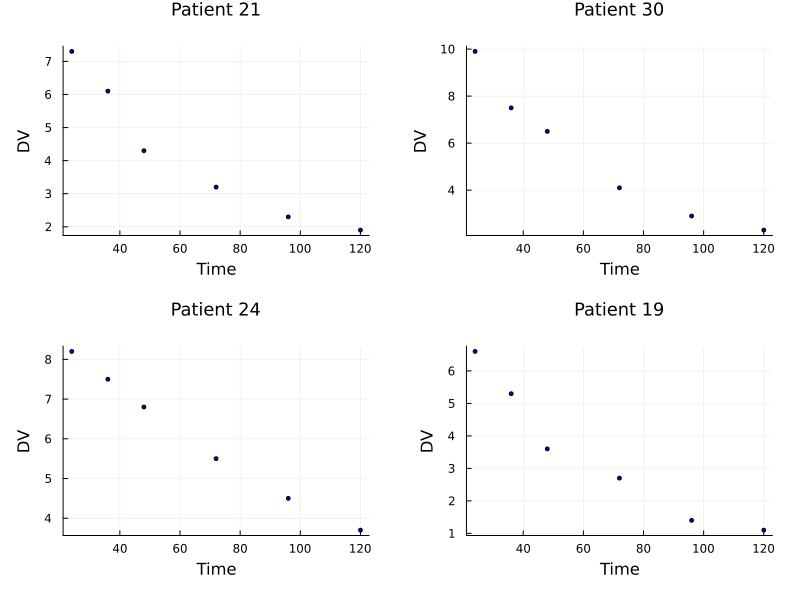

In [115]:
# Graph 4 random patients
#Random.seed!(1)

patients = unique(df_pk.ID);

# Create an array to store scatter plots
scatter_plots = Plots.Plot[]

# Loop through each patient
for i in patients[rand(1:length(patients), 4)]
    df_plot = df_pk[df_pk.ID .== i, :]
   
    x_values = df_plot.TIME
    y_values = df_plot.DV

    push!(scatter_plots, scatter(x_values, 
                                 y_values,
                                 xlabel="Time",
                                 ylabel="DV",
                                 title="Patient $i",
                                 legend = false,
                                 markersize=2,
                                 markercolor=:blue,
                                 titlefont=font(12)
                                 )
            )
end

# Combine scatter plots into a grid layout
plot_grid = plot(scatter_plots..., layout=(2, 2), size=(800, 600), margin=5mm)

# Show the combined plot
display(plot_grid)

## Modeling

In [116]:
first(df_pk,20)

Row,ID,TIME,WEIGHT,AGE,SEX,AMT,DV
,Int64,Float64,Float32,Float32,Int64,Float32,Float32
1,100,0.5,0.952857,1.25,1,1.0,0.0
2,100,1.0,0.952857,1.25,1,1.0,1.9
3,100,2.0,0.952857,1.25,1,1.0,3.3
4,100,3.0,0.952857,1.25,1,1.0,6.6
5,100,6.0,0.952857,1.25,1,1.0,9.1
6,100,9.0,0.952857,1.25,1,1.0,10.8
7,100,12.0,0.952857,1.25,1,1.0,8.6
8,100,24.0,0.952857,1.25,1,1.0,5.6
9,100,36.0,0.952857,1.25,1,1.0,4.0


In [124]:
function get_patient_data(id; dim_augmentations = 0)
    patient = sort(df_pk[df_pk.ID .== id, :], :TIME);
    weight = float.([patient.WEIGHT[1]])[1]
    age = float.([patient.AGE[1]])[1]
    sex = float.([patient.SEX[1]])[1]
    amt = float.([patient.AMT[1]])[1]
    t = float.(patient.TIME)
    dv = float.(patient.DV)

    dv0 = 0.0
    u0 = [dv0, weight, age, sex, amt]

    augmented = Float64.(zeros(dim_augmentations))'
    append!(u0, augmented)

    return u0, t, dv
end

# Neural network architecture
function neural_network(dim_augmentations)
    model = Chain(Dense(5 + dim_augmentations, 64, swish), 
                  Dense(64, 16, swish),
                  Dense(16, 4, swish),
                  Dense(4, 5)
                  ) |> f64
    return model
end

function predict(prob, u0, p, saveat)
    Array(solve(prob, Tsit5(), u0 = u0, p = p, saveat = saveat))
end

# Loss function for multiple patients
function loss_function_multi_patients(p, patient_ids; metric = "mse")
    local ys, ts, u0s, errors, prob
    prob = []
    ts = []
    ys = []
    u0s = []
    for (ix, id) in enumerate(patient_ids)
        Zygote.ignore() do
            u0, t, y = get_patient_data(id; dim_augmentations = dim_augmentations)
            push!(prob, ODEProblem(dudt, u0, (0, maximum(t))))
            push!(ts, t)
            push!(ys, y)
            push!(u0s, u0)
        end
    end
    if metric == "mse"
        errors = map((prob, t, y, u0) -> Flux.mse(predict(prob, u0, p, t)'[:,1], y), prob, ts, ys, u0s)
    elseif metric == "mae"
        errors = map((prob, t, y) -> Flux.mae(predict(prob, u0, p, t)'[:,1], y), prob, ts, ys)
    elseif metric == "mape"
        errors = map((prob, t, y) -> sum(abs.(predict(prob, u0, p, t)'[:,1] - y)/y)/length(y), prob, ts, ys)
    end
    
    return sum(errors)/length(patient_ids)
end

# Callback function to print losses during training. Set print_losses to false to disable
callback = function (p, loss; print_losses = true)
    global iter
    if print_losses
        iter += 1
        if iter % 10 == 0
            println("Iteration number $iter. Loss = $loss")
        end
    end
    return false
end

#204 (generic function with 1 method)

In [125]:
dim_augmentations = 0
dudt2 = neural_network(dim_augmentations)
p, re = Flux.destructure(dudt2)
dudt(u, p, t) = re(p)(u)

# Select automatic differentiation from Zygote
adtype = Optimization.AutoZygote()

# Define the optimization function. It will be the loss function and the gradients will be calculated with adtype
optf = Optimization.OptimizationFunction((p, _) -> loss_function_multi_patients(p, [100]; metric = "mse"), adtype)

# Define optimization problem. For this, the optimization problem is chosen and the initialization of parameters are given
optprob = Optimization.OptimizationProblem(optf, p)

# Solve the optimization problem using ADAM
iter = 0
result = Optimization.solve(optprob,
    Adam(0.01);
    callback = callback,
    maxiters = 500);

DimensionMismatch: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(1),), b has dims (Base.OneTo(5),), mismatch at 1

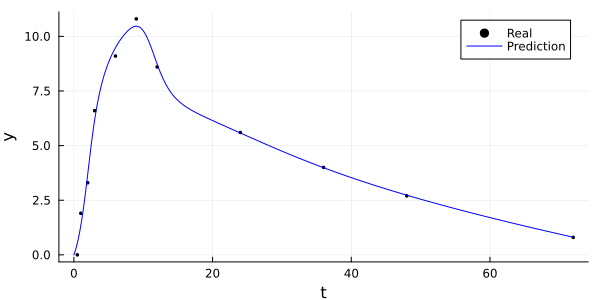

In [123]:
u0_test, t_test, y_test = get_patient_data(100; dim_augmentations = dim_augmentations)
t_max = maximum(t_test)

prob = ODEProblem(dudt, u0_test, (0, t_max))

plt = scatter(t_test, y_test, size=(600, 300), color=:black, markersize=2, xlabel="t", ylabel="y", label="Real")
plot!(plt, collect(0:0.1:t_max), predict(prob, u0_test, result.u, 0:0.1:t_max)'[:,1], color=:blue, markersize=2, label="Prediction")
display(plt)

In [89]:
predict(prob, u0_test, result.u, 1)

5×73 Matrix{Float64}:
 0.0       1.5604    3.78264   …    0.950677    0.891278    0.83415
 0.952857  0.61467   0.379318      14.3429     14.38       14.4157
 1.25      2.30361   2.7843        -8.10455    -8.23136    -8.35903
 1.0       0.562414  0.112009      -4.03322    -4.06589    -4.10175
 1.0       2.25903   4.18369      -10.6401    -10.8443    -11.0465

In [73]:
t_test

10-element Vector{Float64}:
  1.0
  2.0
  3.0
  6.0
  9.0
 12.0
 24.0
 36.0
 48.0
 72.0